# Movement of particles in a cylindrical geometry

This demo shows the movement of particles and reflection from walls in a cylindricaly bounded 
geometry.

## Prepare simulation

Import libraries, create default configuration and get pointers to data.

In [1]:
import parfis as pfs
from parfis import Parfis
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from copy import copy

Parfis.load_lib()
id = Parfis.newParfis()

Successfully loaded lib file: libparfis64.so


In [2]:
Parfis.loadCfgData(id)
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.loadSimData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)

Let's check the distribution of velocities and their range. Default value for the velocity vector is that it can go from zero to one $\textbf{|v|} \in (0.0, 1.0)$. This defines the maximum distance of one cell that a particle can travel in a single step.

In [3]:
print(f"""
Initial velocity distribution = {ptrSimData.specieVec.ptr[0].velInitRandom.decode()}
Velocity is between 
    min (vx, vy, vz) = {ptrSimData.specieVec.ptr[0].velInitDistMin.asTuple()} and 
    max (vx, vy, vz) = {ptrSimData.specieVec.ptr[0].velInitDistMax.asTuple()}
""")


Initial velocity distribution = uniform
Velocity is between 
    min (vx, vy, vz) = (-0.5773502691, -0.5773502691, -0.5773502691) and 
    max (vx, vy, vz) = (0.5773502691, 0.5773502691, 0.5773502691)



We see that the velocity components range from $-\sqrt{1/3}$ to $\sqrt{1/3}$, which makes the magnitute of the velocity vector as described above. In order to have a smooth moving particles we can decrees the speed, for example by 100. This can be reconfigured in a single string, and set directly to the config parameters.

In [4]:
print((ptrSimData.specieVec.ptr[0].velInitDistMin*0.01).asList())

[-0.005773502691, -0.005773502691, -0.005773502691]


In [5]:
cfgStr = f"""
particle.specie.a.velInitRandom = uniform <std::string>
particle.specie.a.velInitDistMin = {(ptrSimData.specieVec.ptr[0].velInitDistMin*0.01).asList()} <double>
particle.specie.a.velInitDistMax = {(ptrSimData.specieVec.ptr[0].velInitDistMax*0.01).asList()} <double>
"""
print(cfgStr)


particle.specie.a.velInitRandom = uniform <std::string>
particle.specie.a.velInitDistMin = [-0.005773502691, -0.005773502691, -0.005773502691] <double>
particle.specie.a.velInitDistMax = [0.005773502691, 0.005773502691, 0.005773502691] <double>



In [6]:
Parfis.setConfig(id, cfgStr)
Parfis.loadCfgData(id)
Parfis.loadSimData(id)
success = Parfis.runCommandChain(id, "create")
print("Create success") if success == 0 else print("Create fail")
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)
cellSize =ptrCfgData.cellSize[0]
geoSize =ptrCfgData.geometrySize[0]
cellCount =ptrCfgData.cellCount[0]
print(f"cellSize = {cellSize} meters")
print(f"geoSize = {geoSize} meters")
print(f"cellCount = {cellCount}")

Create success
cellSize = {x: 0.001, y: 0.001, z: 0.001} meters
geoSize = {x: 0.02, y: 0.02, z: 0.4} meters
cellCount = {x: 20, y: 20, z: 400}


## Movement in a single cell

First we will look how particles move in a single cell. We choose a cell in the middle of the 
geometry (not touching any boundary). What can be seen is yellow particles that exist at the begining
of the simultaion in the given cell. When a particle enters the cell from one of the neigbouring cells
we mark the entry point as green. When a particle leaves the cell we mark the exit point as red. Since 
the cell is given in two cross sections, it is noticeable that every exit or entry point must have its mark
on one of the 6 cell boundaries.

In [22]:
# Number of frames to run the simulation
numFrames = 100
# Size of a particle in the animation
particleSize = 0.015*cellSize.x
# Save animation as mp4
saveAnimation = True

cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(x=10, y=10, z=50)
cellId = ptrSimData.cellIdVec.ptr[pfs.getAbsoluteCellId(cellCount, cellPos)]
cellIdRange = [cellId]

# Dictionary of the format {stateId: [patchId, pushed]}
knownState = dict()

pc = ['blue', 'red']

# Draw the cell
fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].set_title("Cell x-y")
ax[0].plot()
ax[1].set_title("Cell z-y")
ax[1].plot()

xRange = [i for i in range(10, 12)]
yRange = [i for i in range(10, 12)]
zRange = [i for i in range(50, 52)]

ax[0].set_xlim(xRange[0]*cellSize.x, xRange[-1]*cellSize.x)
ax[0].set_ylim(yRange[0]*cellSize.y, yRange[-1]*cellSize.y)
ax[0].set_aspect('equal')
ax[0].set_xlabel('x-axis')
ax[0].set_ylabel('y-axis')
ax[1].set_xlim(zRange[0]*cellSize.z, zRange[-1]*cellSize.z)
ax[1].set_ylim(yRange[0]*cellSize.y, yRange[-1]*cellSize.y)
ax[1].set_aspect('equal')
ax[1].set_xlabel('z-axis')
ax[1].yaxis.set_visible(False)

gridPatches = []
pos = ptrSimData.cellVec.ptr[cellId].pos
gridPatches.append (
    patches.Rectangle(
        (cellSize.x*pos.x, cellSize.y*pos.y),
        cellSize.x, cellSize.y,
        edgecolor = 'blue',
        alpha = 0.5,
        fill=False
    ) 
)

for i in range(len(gridPatches)):
    ax[0].add_patch(copy(gridPatches[i]))
    ax[1].add_patch(copy(gridPatches[i]))

iniParts = True

def update(i):
    global iniParts
    Parfis.runCommandChain(id, "evolve")

    for cid in cellIdRange:
        xOff = ptrSimData.cellVec.ptr[cid].pos.x*cellSize.x
        yOff = ptrSimData.cellVec.ptr[cid].pos.y*cellSize.y
        zOff = ptrSimData.cellVec.ptr[cid].pos.z*cellSize.z
        stateId = ptrSimData.headIdVec.ptr[cid]
        while stateId != pfs.Const.noStateId:
            state = ptrSimData.stateVec.ptr[stateId]
            # If new state - add patch for it
            if stateId not in knownState.keys():
                if not iniParts:
                    ax[0].add_patch(
                        patches.Circle(
                            (
                                state.pos.x*cellSize.x + xOff, 
                                state.pos.y*cellSize.y + yOff),
                            radius=particleSize,
                            color='green',
                            fill=True
                        )
                    )
                    ax[1].add_patch(
                        patches.Circle(
                            (
                                state.pos.z*cellSize.z + zOff, 
                                state.pos.y*cellSize.y + yOff),
                            radius=particleSize,
                            color='green',
                            fill=True
                        )
                    )
                ax[0].add_patch(
                    patches.Circle(
                        (
                            state.pos.x*cellSize.x + xOff, 
                            state.pos.y*cellSize.y + yOff),
                        radius=particleSize,
                        color='yellow',
                        fill=True
                    )
                )
                ax[1].add_patch(
                    patches.Circle(
                        (
                            state.pos.z*cellSize.z + zOff, 
                            state.pos.y*cellSize.y + yOff),
                        radius=particleSize,
                        color='yellow',
                        fill=True
                    )
                )
                knownState[stateId] = [len(ax[0].patches) - 1, 1]
                
            else:                
                ax[0].patches[knownState[stateId][0]].center = (
                    state.pos.x*cellSize.x + xOff, 
                    state.pos.y*cellSize.y + yOff)
                ax[0].patches[knownState[stateId][0]].set_color('gold')
                ax[1].patches[knownState[stateId][0]].center = (
                    state.pos.z*cellSize.z + zOff, 
                    state.pos.y*cellSize.y + yOff)
                ax[1].patches[knownState[stateId][0]].set_color('gold')
                knownState[stateId][1] = 1

            stateId = state.next

    for stateId in knownState.keys():
        if knownState[stateId][1] == 0:
            ax[0].patches[knownState[stateId][0]].set_color('red')
            ax[1].patches[knownState[stateId][0]].set_color('red')
        else:
            knownState[stateId][1] = 0
            
    iniParts = False

    return ax[0].patches + ax[1].patches

anim = animation.FuncAnimation(fig, update, frames=numFrames, blit=True, interval=50)

if saveAnimation:
    from IPython import display
    plt.ioff()
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()
else:
    plt.show()

## Movement in cells close to the boundary

Now let's choose some cells that are close to the boundary.

Selected 11 cells for presentation


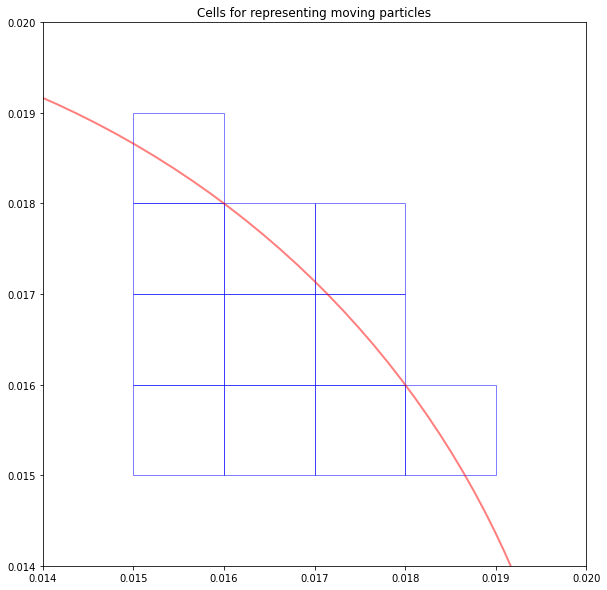

In [23]:
zSlice = 50
xRange = [i for i in range(15, 20)]
yRange = [i for i in range(15, 20)]
cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(z=zSlice)
cellIdRange = []
for i in xRange:
    cellPos.x = i
    for j in yRange:
        cellPos.y = j
        cellId =ptrSimData.cellIdVec.ptr[pfs.getAbsoluteCellId(cellCount, cellPos)]
        if cellId != pfs.Const.noCellId:
            cellIdRange.append(cellId)
print(f"Selected {len(cellIdRange)} cells for presentation")

# Save grid patches for later drawings

# Draw the cells
fig, axGrid = plt.subplots(figsize=(10, 10))
axGrid.set_title("Cells for representing moving particles")
axGrid.plot()

gridPatches = []
for cellId in cellIdRange:
    pos =ptrSimData.cellVec.ptr[cellId].pos
    gridPatches.append (
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
gridPatches.append (
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)

for i in range(len(gridPatches)):
    axGrid.add_patch(copy(gridPatches[i]))
axGrid.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
axGrid.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
axGrid.set_aspect('equal')
plt.show()

If we evolve the system long enough we can see that particles don't cross the boundary
and that the reflection algorithm works well. The vanishing and emerging particles
are particles that exit and enter the cell of the represented domain.

In [24]:
# Number of frames to run the simulation
numFrames = 2000
# Size of a particle in the animation
particleSize = 0.02*cellSize.x
# Save animation as mp4
saveAnimation = True

# Dictionary of the format {stateId: [patchId, pushed]}
knownState = dict()

pc = ['blue', 'red']

# Draw the cells
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Particles moving close to the boundary and reflecting")
ax.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
ax.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
ax.set_aspect('equal')

for i in range(len(gridPatches)):
    ax.add_patch(copy(gridPatches[i]))

def update(i):
    Parfis.runCommandChain(id, "evolve")
        
    for cid in cellIdRange:
        xOff = ptrSimData.cellVec.ptr[cid].pos.x*cellSize.x
        yOff = ptrSimData.cellVec.ptr[cid].pos.y*cellSize.y
        stateId = ptrSimData.headIdVec.ptr[cid]
        while stateId != pfs.Const.noStateId:
            state = ptrSimData.stateVec.ptr[stateId]
            # If new state - add patch for it
            if stateId not in knownState.keys():
                ax.add_patch(
                    patches.Circle(
                        (
                            state.pos.x*cellSize.x + xOff, 
                            state.pos.y*cellSize.y + yOff),
                        radius=particleSize,
                        color='blue',
                        fill=True
                    )
                )
                knownState[stateId] = [len(ax.patches) - 1, 1]
            else: 
                ax.patches[knownState[stateId][0]].center = (
                    state.pos.x*cellSize.x + xOff, 
                    state.pos.y*cellSize.y + yOff)
                knownState[stateId][1] = 1

            stateId = state.next

    for stateId in knownState.keys():
        if knownState[stateId][1] == 0:
            ax.patches[knownState[stateId][0]].set_visible(False)
        else:
            knownState[stateId][1] = 0

    return ax.patches

anim = animation.FuncAnimation(fig, update, frames=numFrames, blit=True, interval=50)

if saveAnimation:
    from IPython import display
    plt.ioff()
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()
else:
    plt.show()